In [117]:
!pip install pmdarima

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import timedelta
from dateutil.parser import parse

In [120]:
path = '/content/drive/MyDrive/Major Project/data/central_data'
os.chdir(path)

In [121]:
cleaned  = pd.read_csv('cleaned.csv', parse_dates=[0])

In [122]:
cleaned.set_index('Day', inplace = True)
cleaned.head()

,public_information_campaigns,stay_home_requirements,close_public_transport,cancel_public_events,testing_policy,stringency_index,vaccination_policy,facial_coverings,total_vaccinations,people_vaccinated,people_fully_vaccinated,mobility_driving,mobility_walking,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
Day,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.35,-0.82,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.96,4.08,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.77,7.41,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.64,13.91,-41.190881,-3.744618,13.019121,-27.015608,-33.823335,-26.076095,0.0,0.0,0.0,0.0,0.0,0.0


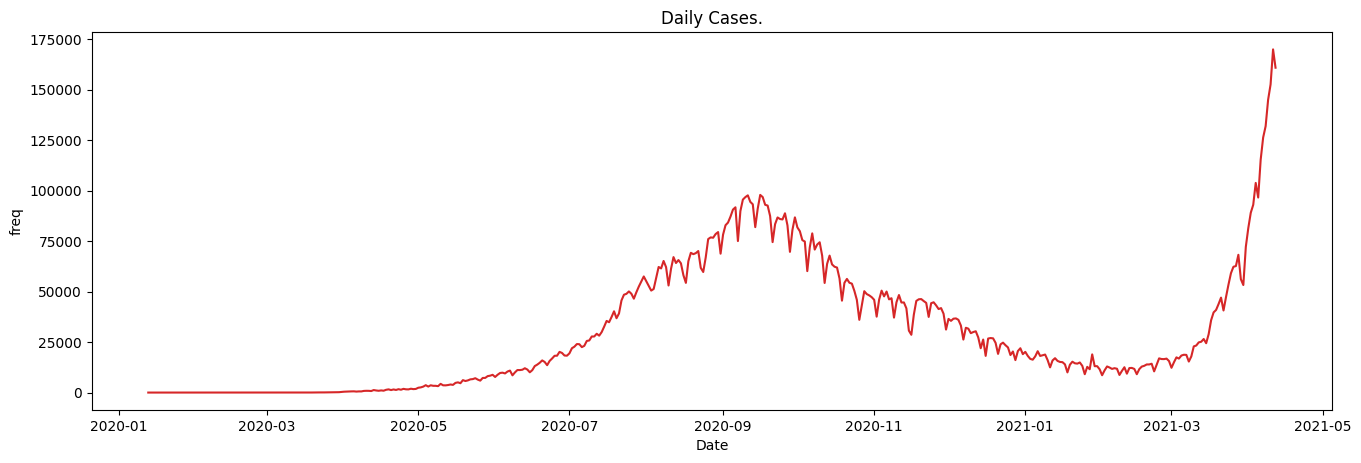

In [123]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='freq', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(cleaned, x=cleaned.index, y=cleaned['Daily Confirmed'], title='Daily Cases.')

**<h2> Seasonality Trend Residual </h2>**

<Figure size 432x288 with 0 Axes>

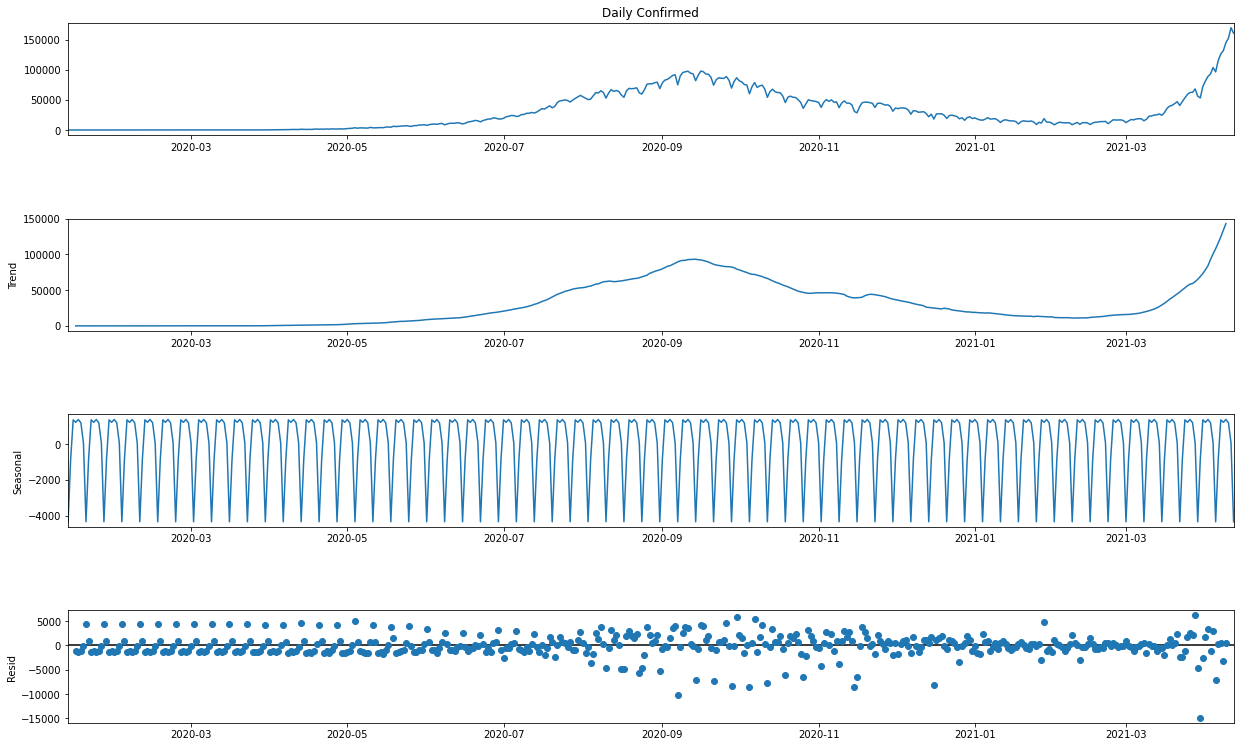

In [124]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(cleaned['Daily Confirmed'], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 12)

**<h2>Testing Stationarity</h2>**

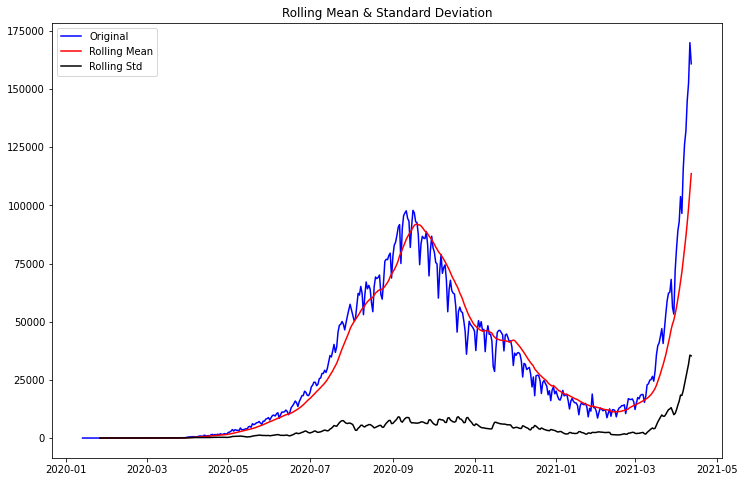

Results of Dickey-Fuller Test:
p-value = 0.9385. The series is likely non-stationary.
Test Statistic                  -0.200294
p-value                          0.938487
#Lags Used                      17.000000
Number of Observations Used    438.000000
Critical Value (1%)             -3.445368
Critical Value (5%)             -2.868161
Critical Value (10%)            -2.570297
dtype: float64


In [9]:
from statsmodels.tsa.stattools import adfuller #adfuller stands for Augmented Dickey-Fuller unit root test.

#The function find mean and standard deviation of the series and and performs augmented dickey fuller test.
#returns pvale .. The smaller the pvalue more stationary is the series.

def test_stationarity(timeseries, window = 14, cutoff = 0.01):
  rolmean = timeseries.rolling(window).mean()
  rolstd = timeseries.rolling(window).std()
  fig = plt.figure(figsize=(12, 8))
  orig = plt.plot(timeseries, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

  print('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC',)
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  pvalue = dftest[1]
  if pvalue < cutoff:
      print('p-value = %.4f. The series is likely stationary.' % pvalue)
  else:
      print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  
  print(dfoutput)

test_stationarity(cleaned['Daily Confirmed'])

In [125]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

start_date = cleaned.index[-1] + timedelta(1)   # 13th April 2021

def getModel( y , X = None, verbose = True):
    model = pm.auto_arima( X = X, y = y , start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=14, max_q=5, # maximum p and q
                      m=1,              # frequency of series 1 for non seasonal data
                      d=None,           # let model determine 'd'
                      max_d = 5,        # by default 2 (only!)
                      seasonal=False,   # No Seasonality
                      trace = verbose,
                      suppress_warnings=True, 
                      stepwise=True,
                      maxiter = 100
                      )
    # if verbose:
    #     print(model.summary())

    return model

def forecast(model, X = None, start_date = start_date, period = 60, field = 'Daily Confirmed'):
    
    fc, confint = model.predict( X = X, n_periods=period , return_conf_int=True)
    index_of_fc = [start_date + timedelta(days) for days in range(period)]

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=index_of_fc)
    fc_series.rename(field, inplace=True)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(16, 5))
    plt.plot(cleaned[field])
    plt.plot(fc_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    plt.title(f"Final Forecast of {field} for {period} days")
    plt.show()
    return fc_series


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8845.327, Time=0.69 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9179.794, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9080.354, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8848.609, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9177.804, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=8837.519, Time=0.47 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=8982.804, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=8819.785, Time=1.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=8947.724, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=8813.005, Time=1.34 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=8944.228, Time=0.12 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=8779.589, Time=0.41 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=8923.786, Time=0.23 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=8466.247, Time=1.35 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept

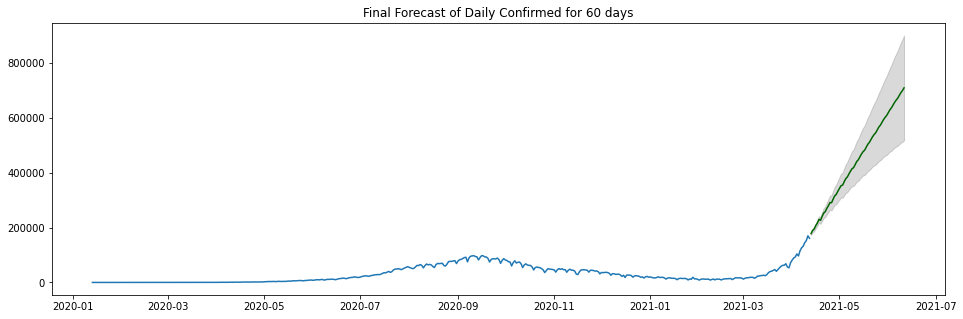

In [126]:
model_DC = getModel(cleaned['Daily Confirmed'])
forecast( model_DC )
pass

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5547.004, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5704.987, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5612.361, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5545.435, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5703.093, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5546.967, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5548.745, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5544.683, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5546.273, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5546.255, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5610.631, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5548.161, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.134 seconds


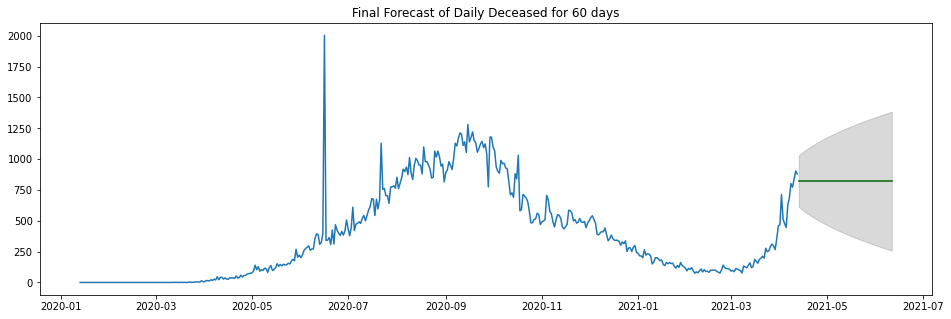

2021-04-13    821.374502
2021-04-14    821.374502
2021-04-15    821.374502
2021-04-16    821.374502
2021-04-17    821.374502
2021-04-18    821.374502
2021-04-19    821.374502
2021-04-20    821.374502
2021-04-21    821.374502
2021-04-22    821.374502
2021-04-23    821.374502
2021-04-24    821.374502
2021-04-25    821.374502
2021-04-26    821.374502
2021-04-27    821.374502
2021-04-28    821.374502
2021-04-29    821.374502
2021-04-30    821.374502
2021-05-01    821.374502
2021-05-02    821.374502
2021-05-03    821.374502
2021-05-04    821.374502
2021-05-05    821.374502
2021-05-06    821.374502
2021-05-07    821.374502
2021-05-08    821.374502
2021-05-09    821.374502
2021-05-10    821.374502
2021-05-11    821.374502
2021-05-12    821.374502
2021-05-13    821.374502
2021-05-14    821.374502
2021-05-15    821.374502
2021-05-16    821.374502
2021-05-17    821.374502
2021-05-18    821.374502
2021-05-19    821.374502
2021-05-20    821.374502
2021-05-21    821.374502
2021-05-22    821.374502


In [127]:
model_DD = getModel(cleaned['Daily Deceased'])
forecast( model = model_DD, field = 'Daily Deceased' )
# 

**<h1>Multi Variate Time Series</h1>**

In [128]:
# target value
Y = cleaned['Daily Confirmed']
drop_list = ['Total Deceased', 'Total Recovered', 'Total Confirmed', 'total_vaccinations', 'Daily Confirmed']
X = cleaned.drop(columns = drop_list)

In [129]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=12)
X_new = selector.fit_transform(X, Y)

In [130]:
selected = X.columns[selector.get_support()]
selected = [col for col in selected]
for s in ['public_information_campaigns', 'cancel_public_events', 'vaccination_policy', 'facial_coverings' ]:
    selected.remove(s)
selected

['stay_home_requirements',
 'testing_policy',
 'stringency_index',
 'people_vaccinated',
 'people_fully_vaccinated',
 'grocery_and_pharmacy',
 'Daily Recovered',
 'Daily Deceased']

In [131]:
# original data of selected features
# start date : 13th Jan 2020 | end date = 12th April  2021
selected_df = cleaned[selected]
selected_df.describe()

,stay_home_requirements,testing_policy,stringency_index,people_vaccinated,people_fully_vaccinated,grocery_and_pharmacy,Daily Recovered,Daily Deceased
count,456.000000,456.000000,456.000000,4.560000e+02,4.560000e+02,456.000000,456.000000,456.000000
mean,2.083333,2.116228,65.205526,4.720202e+06,7.545215e+05,-3.744618,26864.677632,373.899123
std,0.702950,0.768672,24.205176,1.495728e+07,2.420589e+06,19.364295,27305.406031,362.944464
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-64.143000,0.000000,0.000000
25%,2.000000,2.000000,61.570000,0.000000e+00,0.000000e+00,-9.357250,1148.500000,80.250000
50%,2.000000,2.000000,68.980000,0.000000e+00,0.000000e+00,-0.785500,17215.500000,263.000000
75%,3.000000,3.000000,79.170000,0.000000e+00,0.000000e+00,9.429000,46027.750000,582.000000
max,3.000000,3.000000,100.000000,9.504304e+07,1.349005e+07,21.429000,102070.000000,2004.000000


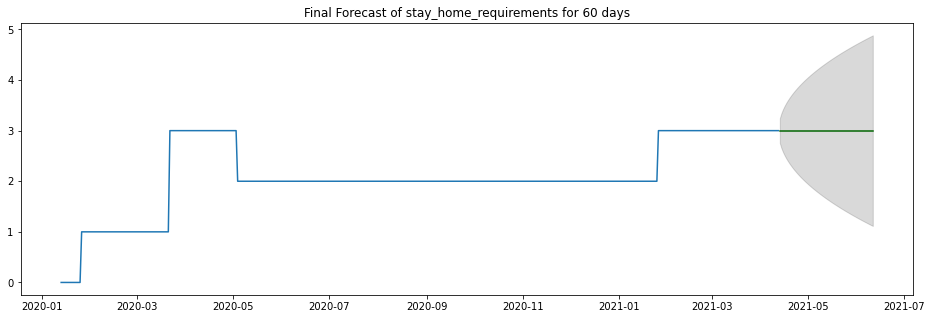

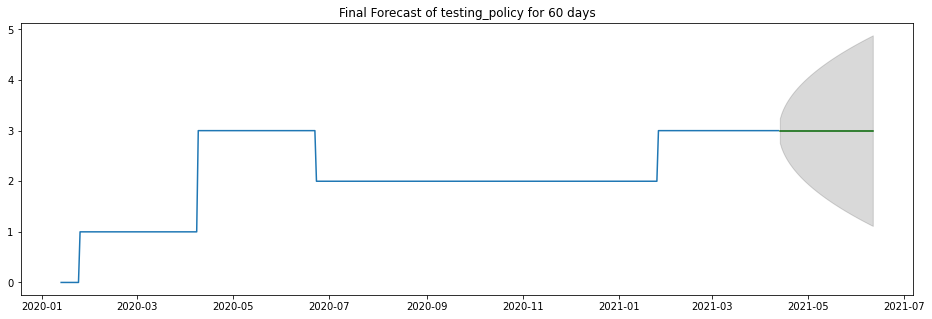

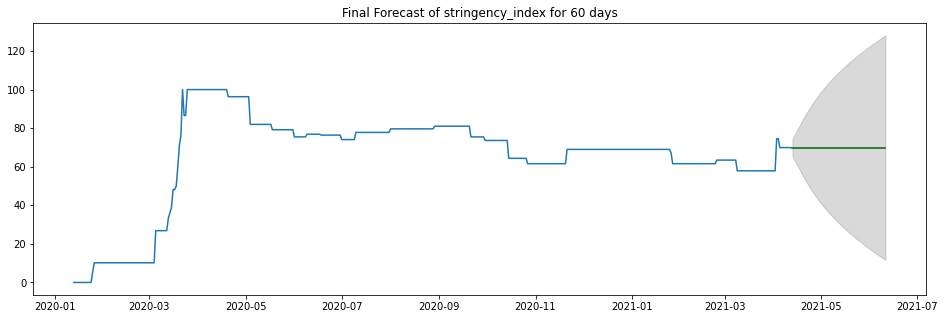

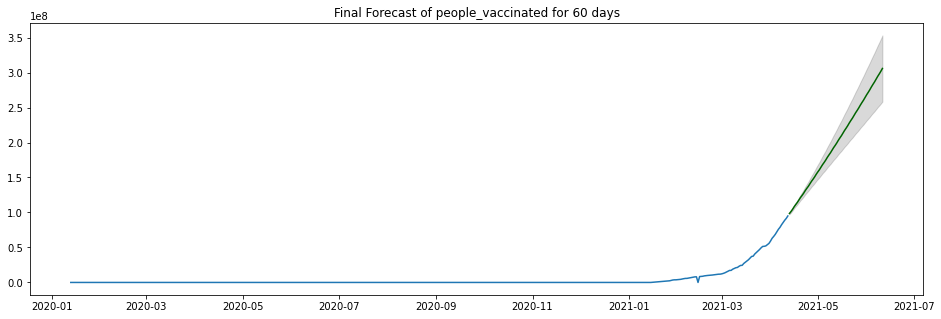

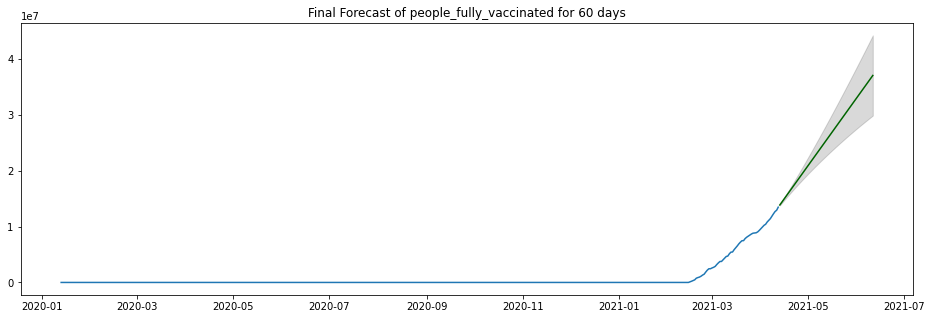

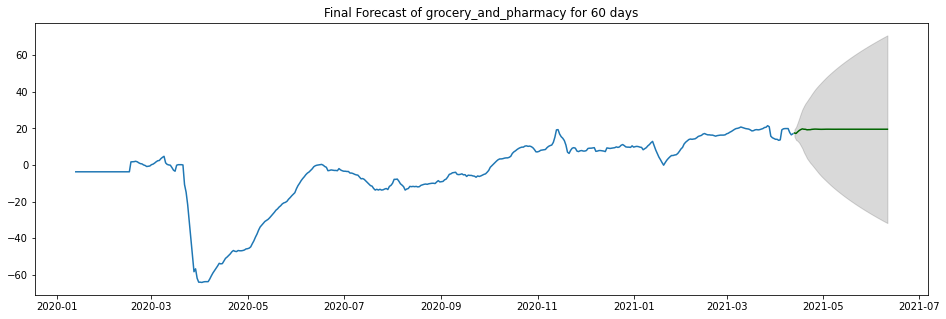

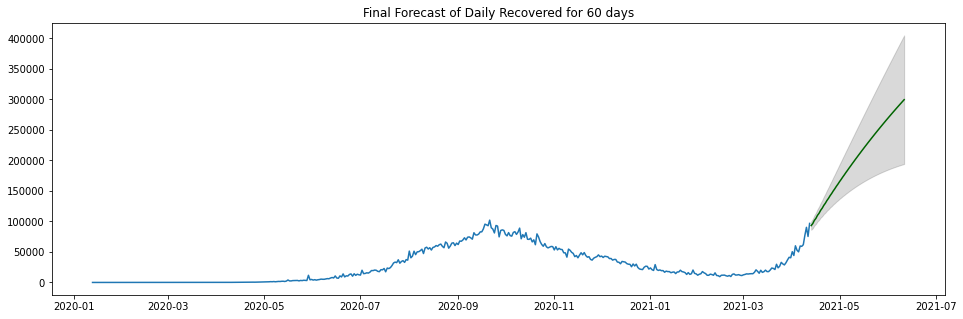

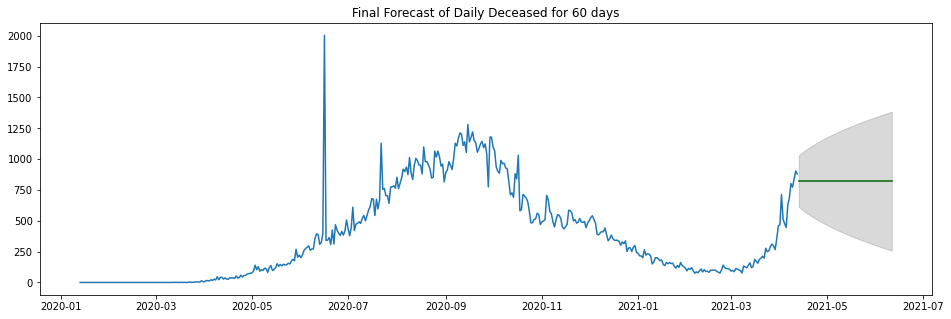

In [17]:
# Univariate predictions of each selected feature
preds = dict()
for col in selected:
    model = getModel(cleaned[col], verbose=False)
    preds[col] = forecast( model, field = col )

In [18]:
# Prediction Data Frame (start date 13th April 2021, forecast of 60 days)
X_preds = pd.concat(preds, axis = 1)
X_preds.head()

,stay_home_requirements,testing_policy,stringency_index,people_vaccinated,people_fully_vaccinated,grocery_and_pharmacy,Daily Recovered,Daily Deceased
2021-04-13,3.0,3.0,69.91,9.853452e+07,1.388347e+07,17.431867,93214.442082,821.374502
2021-04-14,3.0,3.0,69.91,1.014072e+08,1.427689e+07,17.180447,96415.410135,821.374502
2021-04-15,3.0,3.0,69.91,1.045676e+08,1.467031e+07,18.026862,101636.728104,821.374502
2021-04-16,3.0,3.0,69.91,1.081725e+08,1.506373e+07,18.775535,104979.176435,821.374502
2021-04-17,3.0,3.0,69.91,1.113433e+08,1.545716e+07,19.309610,109954.308232,821.374502


# MultiVariate using 12 Features

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=9015.692, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11467.885, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9048.702, Time=0.42 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9073.868, Time=0.66 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18679.916, Time=4.43 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9014.345, Time=3.45 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9061.798, Time=1.52 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=9015.341, Time=1.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8990.347, Time=2.44 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=9050.011, Time=0.81 sec


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1890: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=9158.473, Time=0.91 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=9030.151, Time=0.95 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=9042.149, Time=0.91 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=9025.576, Time=2.29 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=9036.040, Time=0.58 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 22.180 seconds


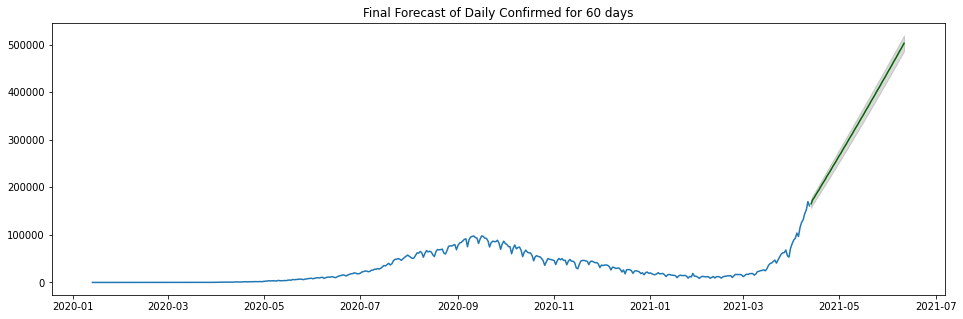

In [132]:
multivariate_model = getModel( cleaned['Daily Confirmed'], selected_df)
forecast( multivariate_model, X = X_preds)
pass

## Multi Variate Model performs quite good (underestimates the data)

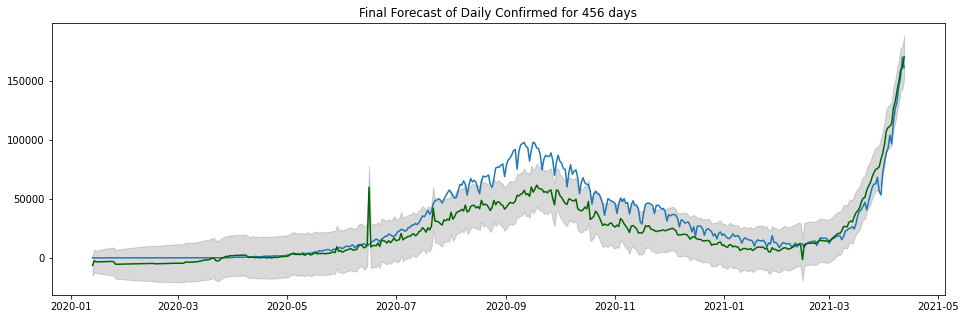

2020-01-13     -6327.663002
2020-01-14     -2436.112507
2020-01-15     -3380.442509
2020-01-16     -3334.661057
2020-01-17     -3289.455717
                  ...      
2021-04-08    141452.334167
2021-04-09    149052.145420
2021-04-10    158785.856860
2021-04-11    160580.663426
2021-04-12    169954.385620
Name: Daily Confirmed, Length: 456, dtype: float64

In [20]:
forecast(multivariate_model, selected_df, cleaned.index[0], period = len(cleaned.index))

# **Univariate model Fails the In sample Test!!**
Highly Overestimates the data

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8845.327, Time=0.67 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9179.794, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9080.354, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8848.609, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9177.804, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=8837.519, Time=0.47 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=8982.804, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=8819.785, Time=1.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=8947.724, Time=0.11 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=8813.005, Time=1.32 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=8944.228, Time=0.12 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=8779.589, Time=0.40 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=8923.786, Time=0.22 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=8466.247, Time=1.34 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept

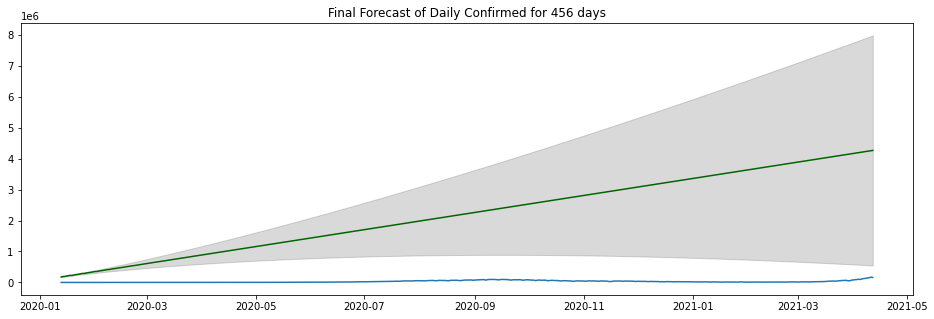

2020-01-13    1.779210e+05
2020-01-14    1.896354e+05
2020-01-15    1.947554e+05
2020-01-16    2.073136e+05
2020-01-17    2.161232e+05
                  ...     
2021-04-08    4.228276e+06
2021-04-09    4.237255e+06
2021-04-10    4.246233e+06
2021-04-11    4.255211e+06
2021-04-12    4.264190e+06
Name: Daily Confirmed, Length: 456, dtype: float64

In [21]:
forecast( getModel(cleaned['Daily Confirmed']) , start_date = cleaned.index[0], period = len( cleaned.index ))

# Training regressor on First Wave and predicting on Second

In [136]:
from sklearn.metrics import mean_squared_error

def regression( model, X, y ):

    trainX, testX = X[:400], X[400:]
    trainY, testY = y[:400], y[400:]
    model.fit(trainX, trainY)

    plt.figure(figsize=[16,5])
    plt.title(f'Forecast of Confirmed Cases for {len(X[400:].index)} Days')
    plt.plot( cleaned['Daily Confirmed'], color = 'blue')

    #in sample test
    y_hat = model.predict(trainX)
    print(f'In sample RMSE: {mean_squared_error ( y_hat , trainY , squared=False)}' )
    plt.plot( y_hat, color = 'darkgreen')

    #out sample test
    y_hat = model.predict(testX)
    print(f'Out Sample RMSE: {mean_squared_error ( y_hat , testY , squared=False) }' )
    plt.plot( np.arange(len(trainX.index), len(trainX.index) + len(y_hat) ), y_hat , color='red')
    
    plt.show()



```
# This is formatted as code
```

## Facebook Prophet

In [ ]:
from fbprophet import Prophet

predictions = {}

for col in selected_df.columns:
    df = selected_df[col].reset_index()
    df.rename(columns = {'Day':'ds', col:'y'}, inplace=True)
    model = Prophet()
    model.fit(df)
    dates = model.make_future_dataframe(periods=60)
    predictions[col] = model.predict(dates)
    predictions[col] = predictions[col][['ds', 'trend']]
    predictions[col].rename( columns = {'trend':col}, inplace=True )

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [ ]:
prophet_df = predictions[selected[0]]
for col in selected_df.columns:
    prophet_df = pd.merge(prophet_df, predictions[col], how = 'left', on = 'ds')

prophet_df.drop(columns = ['stay_home_requirements_x'], inplace = True)
prophet_df.rename(columns = {'stay_home_requirements_y':'stay_home_requirements'}, inplace = True)

prophet_dfX = prophet_df[:456]
prophet_dfY = prophet_df[456:]

y = cleaned['Daily Confirmed'].reset_index()
y.rename(columns = {'Day':'ds', 'Daily Confirmed':'y'}, inplace = True)
prophet_dfX = pd.merge( prophet_dfX, y , how = 'left', on = 'ds' )
prophet_dfX.head()

,ds,stay_home_requirements,stringency_index,people_vaccinated,people_fully_vaccinated,grocery_and_pharmacy,parks,Daily Recovered,Daily Deceased,y
0,2020-01-13,0.281342,-14.460151,273091.200384,32668.795946,-2.157644,15.003052,-1975.201764,-43.538240,0.0
1,2020-01-14,0.304465,-13.345374,271216.981515,32455.808057,-2.394440,14.376137,-1939.314713,-42.598235,0.0
2,2020-01-15,0.327588,-12.230596,269342.762647,32242.820169,-2.631236,13.749222,-1903.427661,-41.658230,0.0
3,2020-01-16,0.350711,-11.115819,267468.543778,32029.832280,-2.868032,13.122308,-1867.540609,-40.718225,0.0
4,2020-01-17,0.373834,-10.001042,265594.324909,31816.844391,-3.104827,12.495393,-1831.653557,-39.778220,0.0


In [ ]:
from fbprophet import Prophet

prophet = Prophet()
for col in selected:
    prophet.add_regressor(col)

prophet.fit(prophet_dfX)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


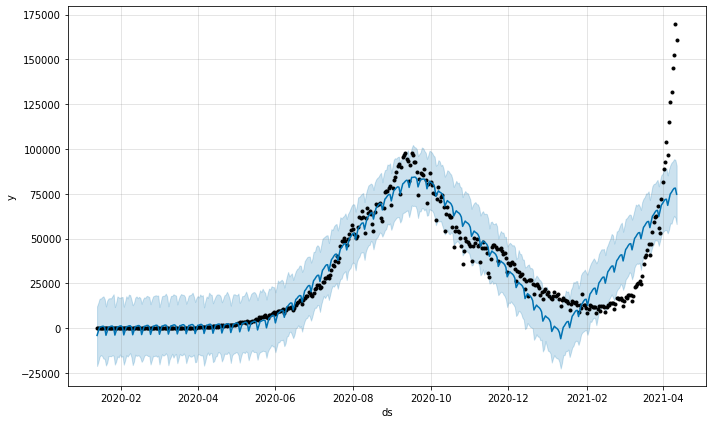

In [ ]:
# insample predictions with Prophet univariate
prophet.plot(prophet.predict())
pass

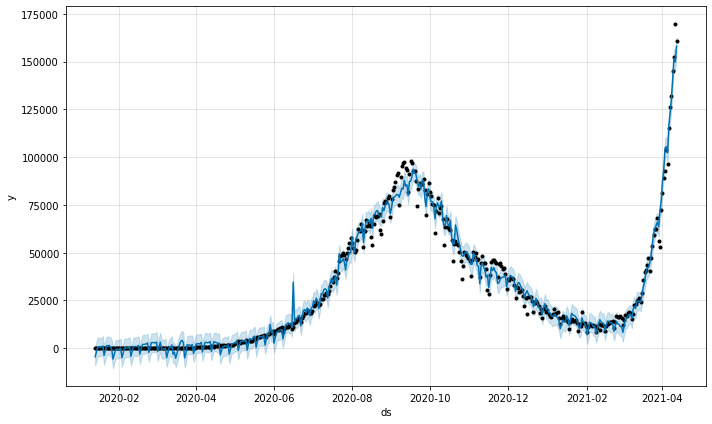

In [ ]:
# insample predictions with Arima univariate
prophet.plot(prophet.predict())
pass

In [ ]:
results = prophet.predict(prophet_dfY)
results

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Daily Deceased,Daily Deceased_lower,Daily Deceased_upper,Daily Recovered,Daily Recovered_lower,Daily Recovered_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,grocery_and_pharmacy,grocery_and_pharmacy_lower,grocery_and_pharmacy_upper,parks,parks_lower,parks_upper,people_fully_vaccinated,people_fully_vaccinated_lower,people_fully_vaccinated_upper,people_vaccinated,people_vaccinated_lower,people_vaccinated_upper,stay_home_requirements,stay_home_requirements_lower,stay_home_requirements_upper,stringency_index,stringency_index_lower,stringency_index_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-04-13,95383.471767,62066.424549,94627.018769,95383.471767,95383.471767,-1898.331738,-1898.331738,-1898.331738,6913.147727,6913.147727,6913.147727,-17527.195755,-17527.195755,-17527.195755,-16063.061499,-16063.061499,-16063.061499,-84312.138950,-84312.138950,-84312.138950,21338.176870,21338.176870,21338.176870,9160.052828,9160.052828,9160.052828,52346.684921,52346.684921,52346.684921,-20383.815336,-20383.815336,-20383.815336,773.162178,773.162178,773.162178,-1464.134256,-1464.134256,-1464.134256,0.0,0.0,0.0,77856.276012
1,2021-04-14,95669.561574,64809.349196,96439.168729,95669.561574,95669.561574,-1812.120517,-1812.120517,-1812.120517,7084.180017,7084.180017,7084.180017,-14584.185974,-14584.185974,-14584.185974,-15463.382162,-15463.382162,-15463.382162,-84712.124134,-84712.124134,-84712.124134,21462.388958,21462.388958,21462.388958,9277.799389,9277.799389,9277.799389,53008.215602,53008.215602,53008.215602,-20553.982114,-20553.982114,-20553.982114,782.260637,782.260637,782.260637,879.196188,879.196188,879.196188,0.0,0.0,0.0,81085.375600
2,2021-04-15,95955.651381,66209.973182,98173.604275,95955.651381,95955.651381,-1725.909297,-1725.909297,-1725.909297,7255.212306,7255.212306,7255.212306,-13889.022817,-13889.022817,-13889.022817,-14863.702826,-14863.702826,-14863.702826,-85112.109318,-85112.109318,-85112.109318,21586.601046,21586.601046,21586.601046,9395.545951,9395.545951,9395.545951,53669.746282,53669.746282,53669.746282,-20724.148891,-20724.148891,-20724.148891,791.359095,791.359095,791.359095,974.680009,974.680009,974.680009,0.0,0.0,0.0,82066.628564
3,2021-04-16,96241.741188,67163.837318,98740.967530,96241.741188,96241.741188,-1639.698076,-1639.698076,-1639.698076,7426.244596,7426.244596,7426.244596,-12940.073603,-12940.073603,-12940.073603,-14264.023489,-14264.023489,-14264.023489,-85512.094502,-85512.094502,-85512.094502,21710.813134,21710.813134,21710.813134,9513.292512,9513.292512,9513.292512,54331.276962,54331.276962,54331.276962,-20894.315669,-20894.315669,-20894.315669,800.457553,800.457553,800.457553,1323.949886,1323.949886,1323.949886,0.0,0.0,0.0,83301.667585
4,2021-04-17,96527.830995,68511.017495,100726.794110,96527.830978,96527.830999,-1553.486855,-1553.486855,-1553.486855,7597.276885,7597.276885,7597.276885,-12302.542089,-12302.542089,-12302.542089,-13664.344153,-13664.344153,-13664.344153,-85912.079686,-85912.079686,-85912.079686,21835.025222,21835.025222,21835.025222,9631.039074,9631.039074,9631.039074,54992.807642,54992.807642,54992.807642,-21064.482447,-21064.482447,-21064.482447,809.556012,809.556012,809.556012,1361.802064,1361.802064,1361.802064,0.0,0.0,0.0,84225.288906
5,2021-04-18,96813.920802,67872.957704,100457.861971,96813.920748,96813.920830,-1467.275635,-1467.275635,-1467.275635,7768.309175,7768.309175,7768.309175,-12435.819220,-12435.819220,-12435.819220,-13064.664816,-13064.664816,-13064.664816,-86312.064870,-86312.064870,-86312.064870,21959.237310,21959.237310,21959.237310,9748.785636,9748.785636,9748.785636,55654.338322,55654.338322,55654.338322,-21234.649225,-21234.649225,-21234.649225,818.654470,818.654470,818.654470,628.845596,628.845596,628.845596,0.0,0.0,0.0,84378.10158

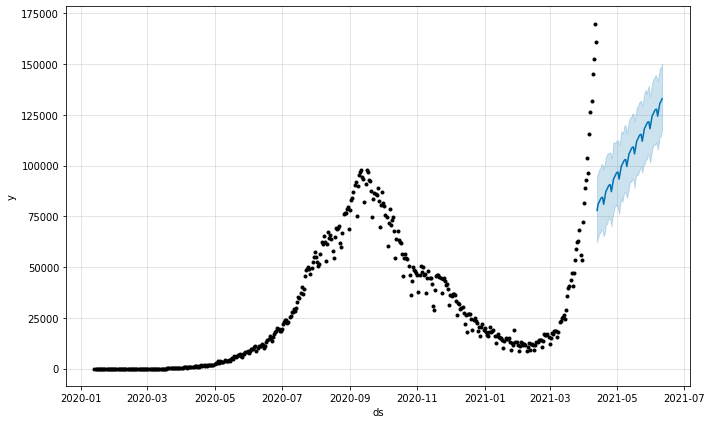

In [ ]:
#out sample predictions with Prophet Univariate
prophet.plot( results )
pass

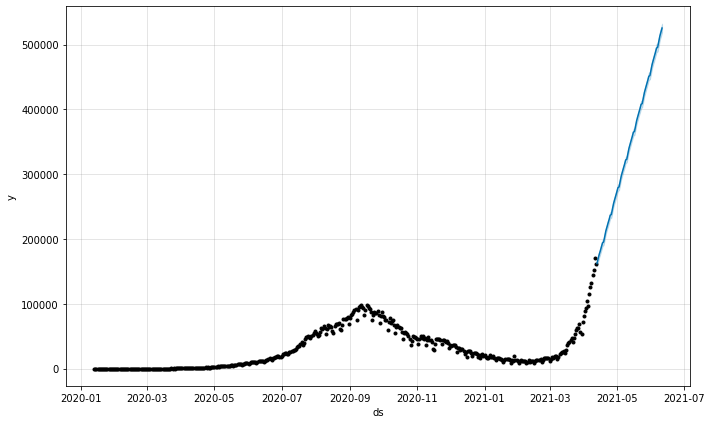

In [ ]:
#out sample predictions with Arima Univariate
prophet.plot( results )
pass